In [1]:
from files.utils import *
from files.darknet import Darknet
import os
import cv2
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
Image.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [2]:
print("[INFO] loading helmet detector model...")
cfg_file = './helmet-detection/model/yolov3-obj.cfg'
weight_file = './helmet-detection/model/yolov3-obj_2400.weights'
namesfile = './helmet-detection/model/obj.names'


m = Darknet(cfg_file)
m.load_weights(weight_file)
class_names = load_class_names(namesfile)

[INFO] loading helmet detector model...



In [3]:
print("[INFO] loading face-mask detector model...")
model = torch.load('./mask-detection/trained-models/model_final.pth')

protext = './mask-detection/face_detector/deploy.prototxt'
weights = './mask-detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNet(protext, weights)

[INFO] loading face-mask detector model...


In [56]:
mask_names = ['Mask', 'No Mask']

def predict(image):
    prediction_transform = transforms.Compose([
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    
    #model.eval()
    prob = model(image)
    idx = torch.argmax(prob)
    
    return idx, prob, mask_names[idx]

In [61]:
def final(img):
    original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    resized_image = cv2.resize(original_image, (m.width, m.height))
    image = resized_image.copy()

    #Helmet
    iou_thresh = 0.3
    nms_thresh = 0.6
    boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

    #Facemask
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    for i in range(0, detections.shape[2]):

        confidence = detections[0, 0, i, 2]

        if confidence > 0.25:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))

            idx, prob, out = predict(face)

            #plt.imshow(image)

            #print(idx, prob[0][idx].item()*100, out)
            color = (0, 255, 0) if out == "Mask" else (255, 0, 0)


            label = "{}: {:.2f}%".format(out, prob[0][idx].item()*100)


            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 1)

    plot_boxes(image, boxes, class_names, plot_labels = True)

### Output



It took 0.808 seconds to detect the objects in the image.

Number of Objects Detected: 2 



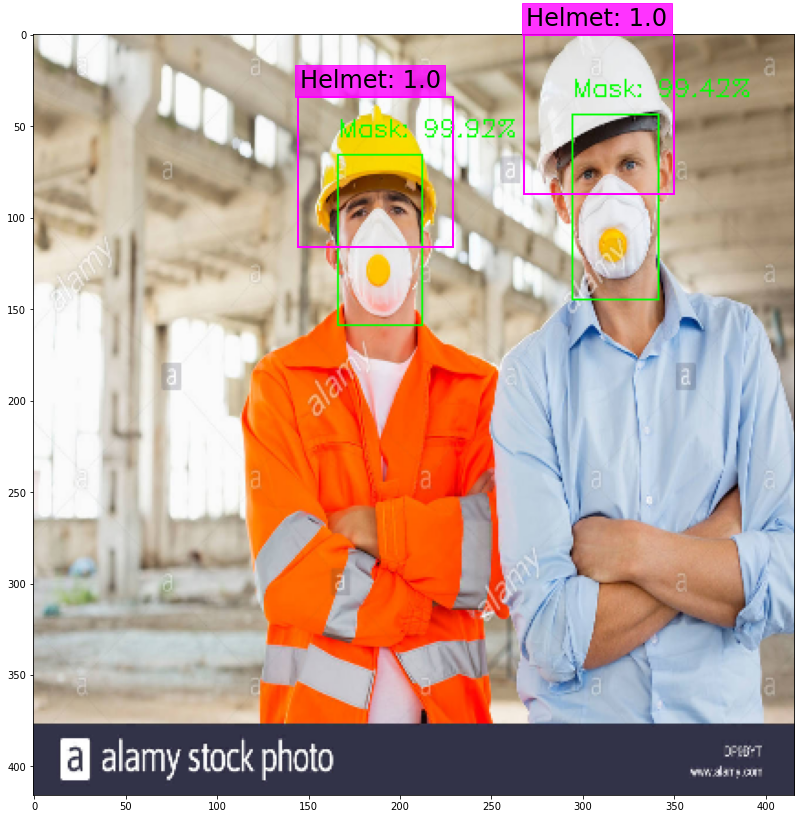

In [63]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/1.jpg')
final(img)



It took 0.813 seconds to detect the objects in the image.

Number of Objects Detected: 1 



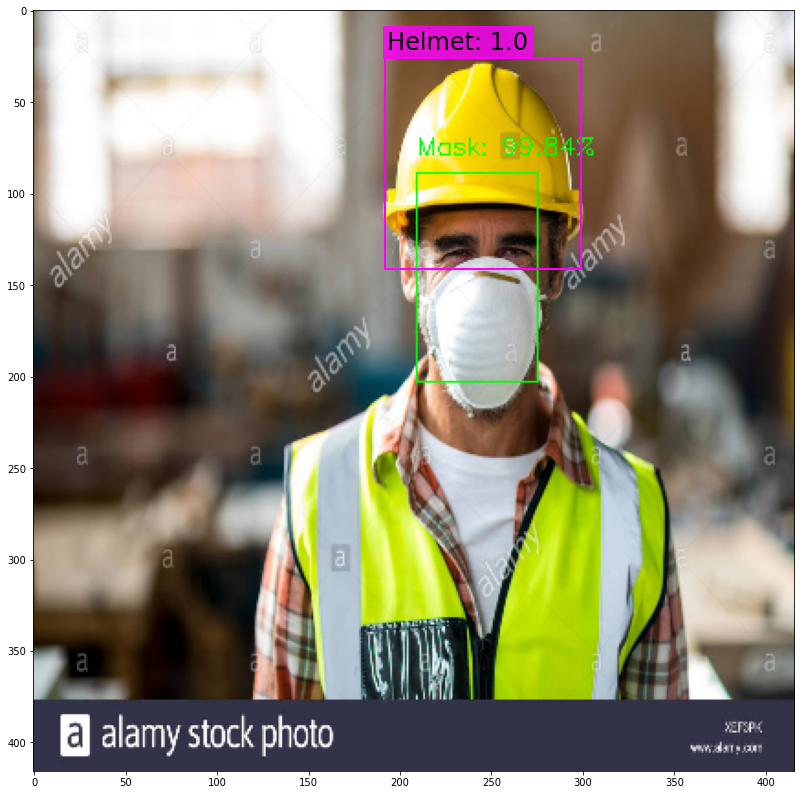

In [64]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/2.jpg')
final(img)



It took 0.842 seconds to detect the objects in the image.

Number of Objects Detected: 0 



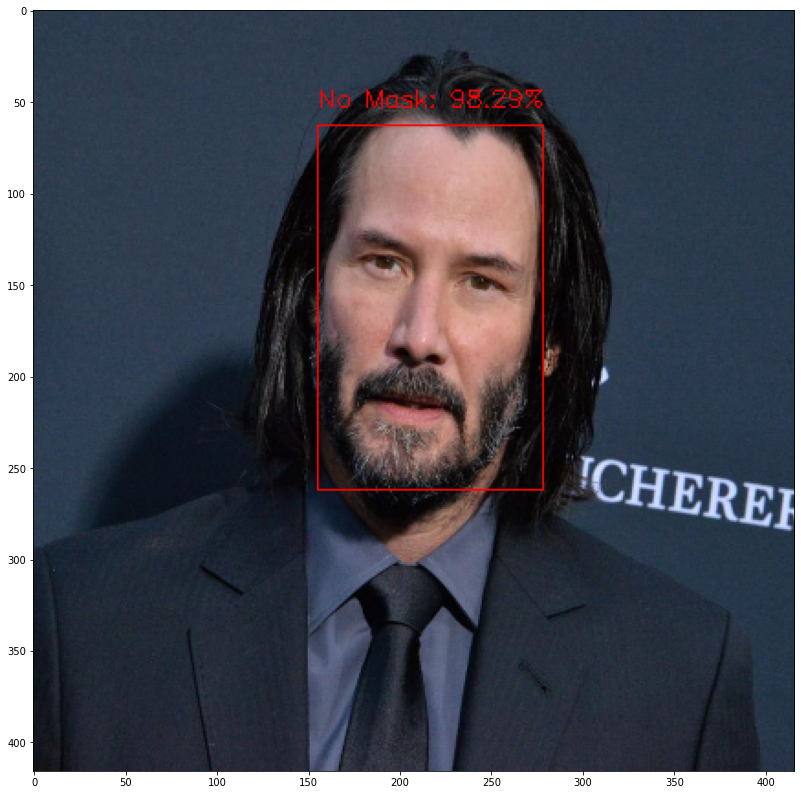

In [71]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/0.jpg')
final(img)



It took 0.844 seconds to detect the objects in the image.

Number of Objects Detected: 2 



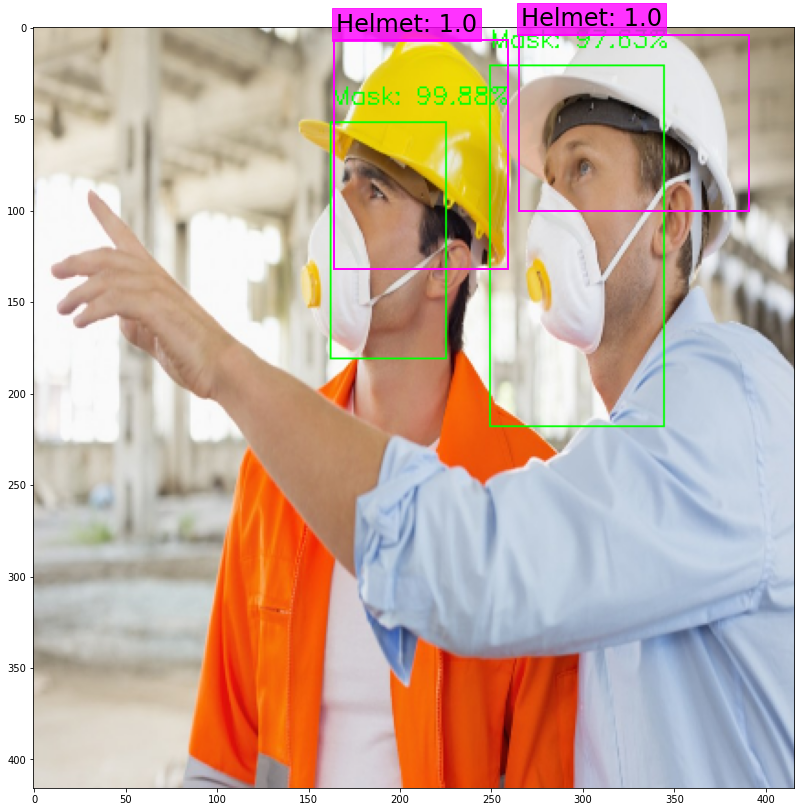

In [65]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/3.jpg')
final(img)



It took 0.817 seconds to detect the objects in the image.

Number of Objects Detected: 1 



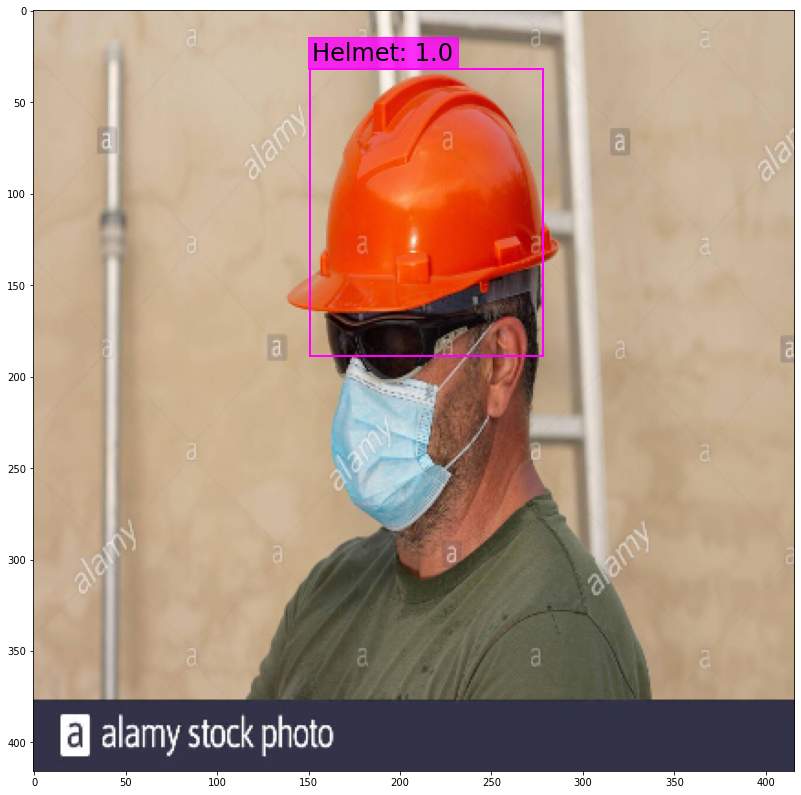

In [66]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/4.jpg')
final(img)



It took 0.812 seconds to detect the objects in the image.

Number of Objects Detected: 1 



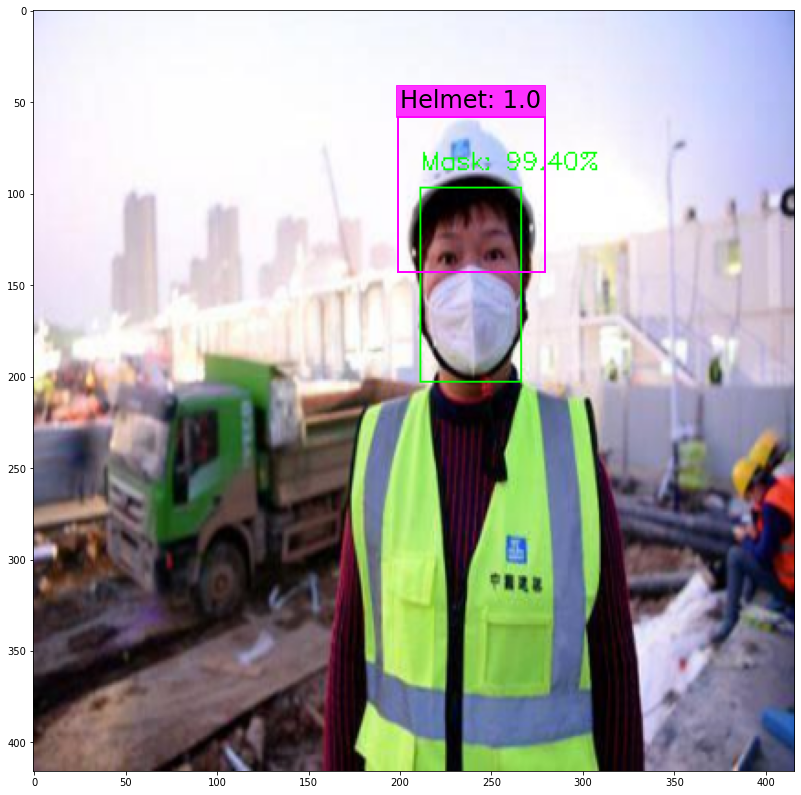

In [69]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/7.jpg')
final(img)



It took 0.809 seconds to detect the objects in the image.

Number of Objects Detected: 1 



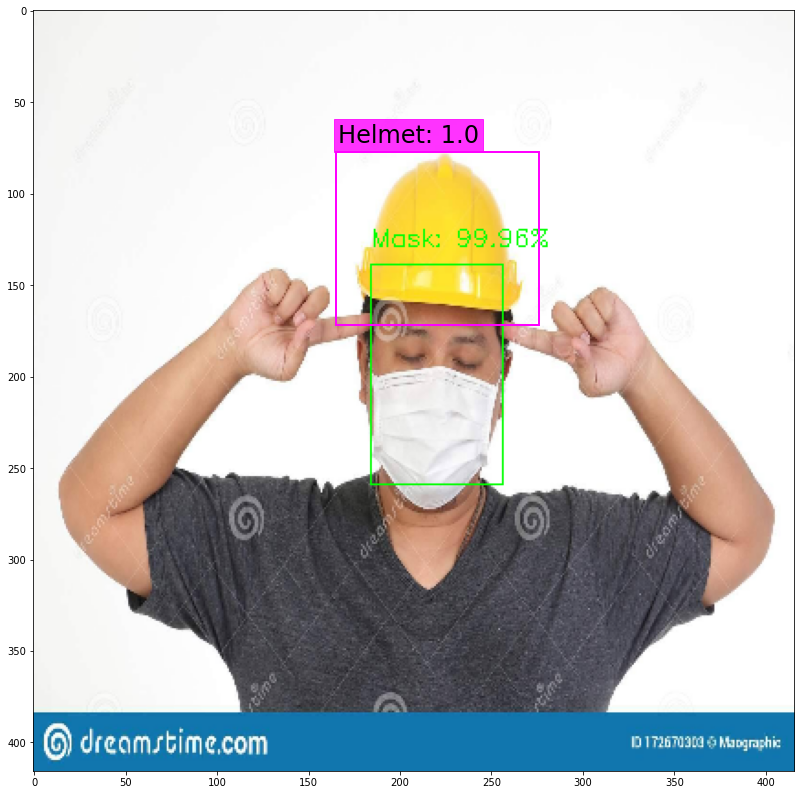

In [70]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./test_images/8.jpg')
final(img)